In [231]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    vector<lower=-1,upper=1>[I] xis;
    xis = 2 * xis_constructors - 1;

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    
    xis_constructors ~ beta(a_xi,b_xi);
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(i in 1:I)
    {
        for (h in 1:H)
            betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(
                y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

18:08:37 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/bayesian.stan to exe file /home/anna-ubuntu/bayesian-project/bayesian
18:11:05 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/bayesian


[[1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.

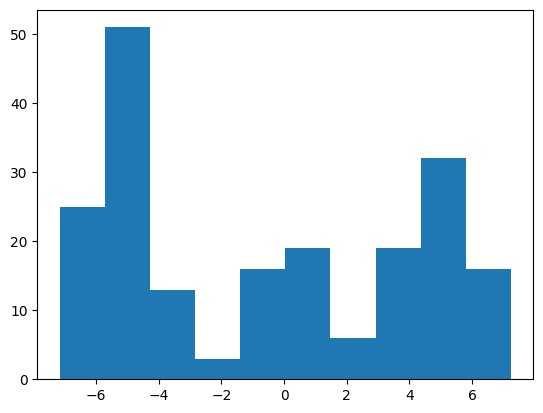

In [232]:
I = 20
T = 10
P = 2
H = 10
means = np.array([-5,0,5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal location 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}


In [233]:
true_clus_allocs

array([0., 0., 0., 2., 0., 2., 2., 2., 0., 2., 2., 1., 0., 0., 0., 2., 1.,
       1., 0., 1.])

In [234]:
fit = dp_mix.sample(data
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

18:18:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                        | 00:00 Status
chain 2 |                                                        | 00:00 Status

chain 3 |                                                        | 00:00 Status


chain 4 |                                                        | 00:00 Status
chain 2 |██▌                                                     | 00:00 Status

chain 3 |██▌                                                     | 00:00 Status


chain 1 |██                     | 02:28 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |██                     | 02:54 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███▏                   | 03:39 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |██                     | 04:08 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███▏                   | 04:16 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |████▏                  | 04:37 Iteration:  200


18:40:57 - cmdstanpy - INFO - CmdStan done processing.
18:40:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[3,13] = 1.21381e+13, but Covariance matrix[13,3] = 1.21381e+13 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 105, column 4 to column 36)
	Exception: multi_normal_lpdf: Covarianc

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


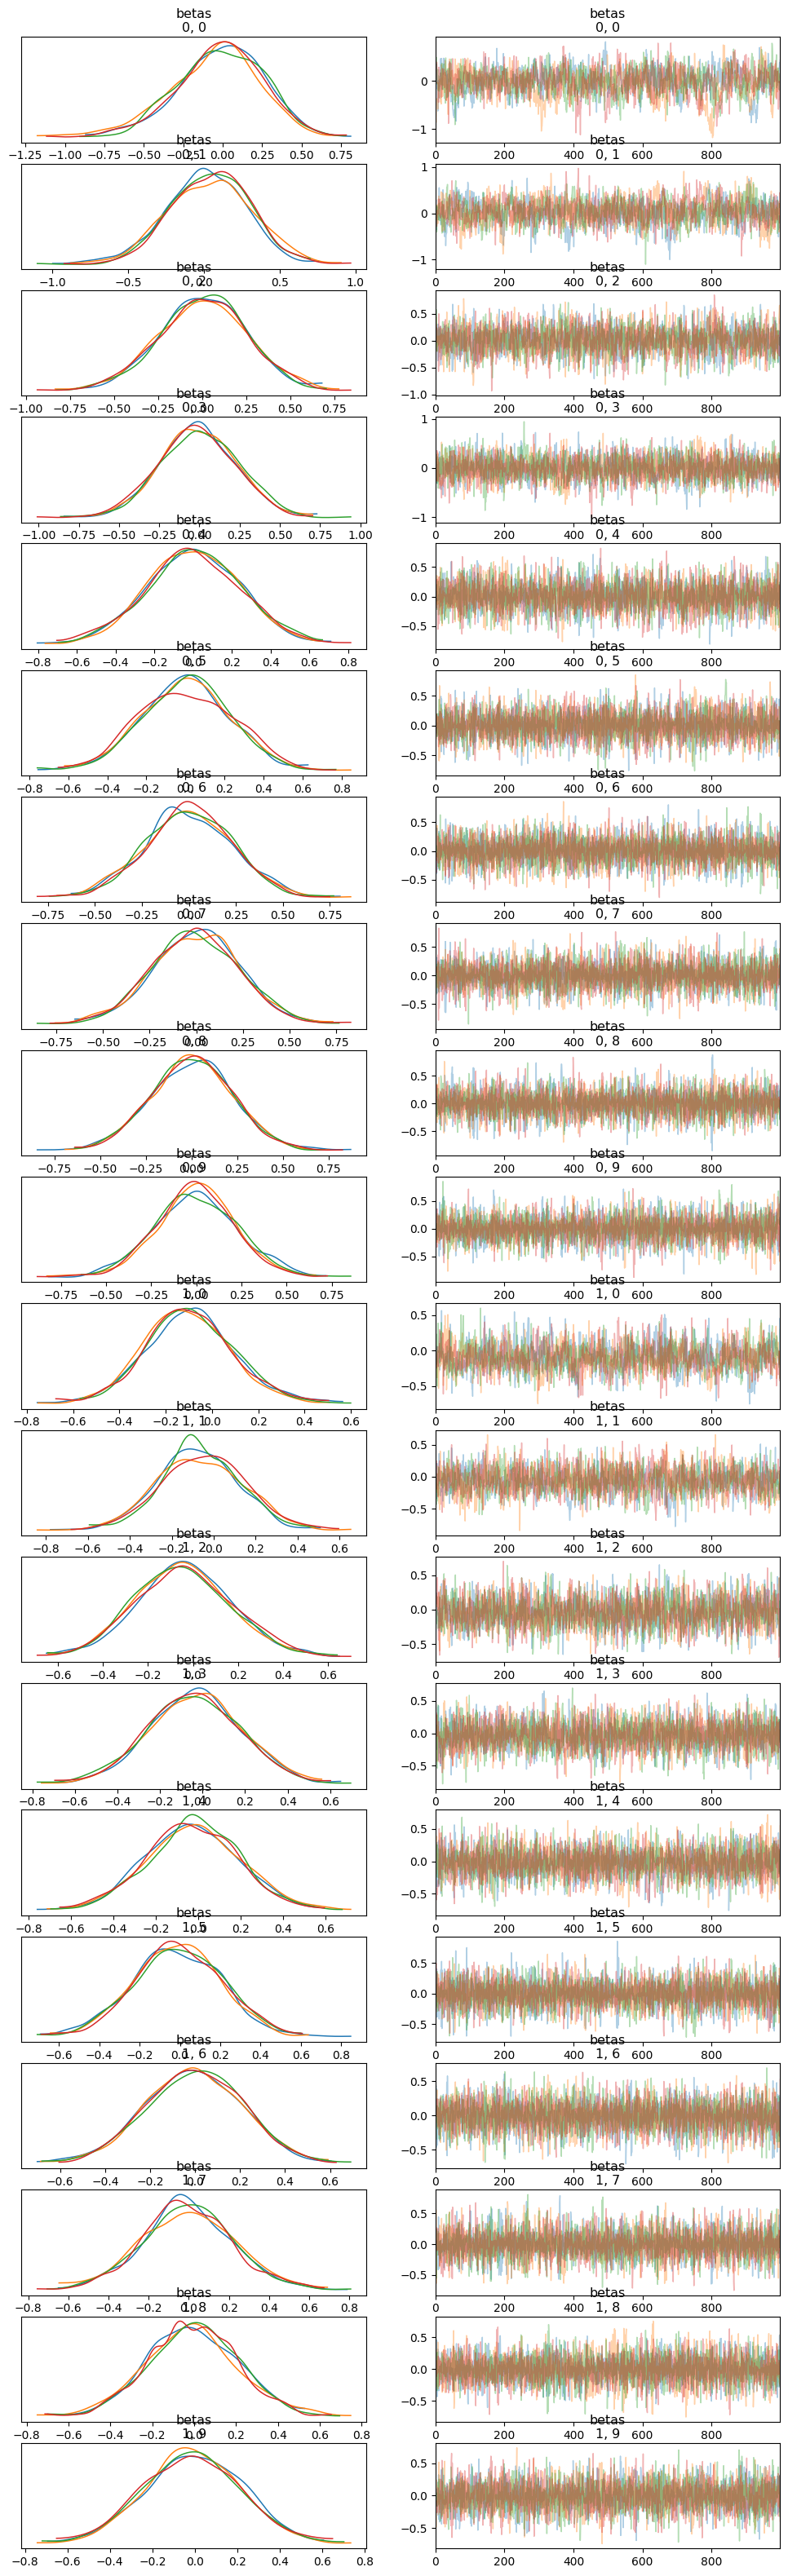

In [235]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [236]:
clus =  np.array(fit_az.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)

# once we have sampling from the posterior we can for istance use binder loss for clustering 

s
[4. 3. 2. 1. 3. 1. 4. 1. 2. 1. 1. 6. 4. 3. 2. 1. 1. 2. 7. 2.]
true clusters
[0. 0. 0. 2. 0. 2. 2. 2. 0. 2. 2. 1. 0. 0. 0. 2. 1. 1. 0. 1.]


In [237]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-554.870000,1.848780,29.025700,-602.631000,-554.789000,-507.291000,246.486,0.098100,1.00781
alpha,1.650130,0.030108,0.873528,0.533480,1.491200,3.312550,841.750,0.335010,1.00310
sigma2,0.416165,0.008177,0.140829,0.224925,0.392520,0.681397,296.636,0.118059,1.00699
tau2,8.341230,0.053388,2.680710,5.101970,7.856930,13.224100,2521.220,1.003430,1.00005
rho,0.146852,0.001494,0.079466,0.051669,0.130692,0.292840,2827.560,1.125350,1.00046
...,...,...,...,...,...,...,...,...,...
"log_probs[20,6]",-19.141200,0.234695,7.981860,-33.848700,-17.403400,-10.455600,1156.640,0.460335,1.00687
"log_probs[20,7]",-19.981300,0.256363,8.186010,-35.488100,-18.084100,-10.878600,1019.610,0.405798,1.00559
"log_probs[20,8]",-21.019300,0.280105,8.820800,-37.560100,-19.001200,-11.542200,991.689,0.394684,1.00576
"log_probs[20,9]",-21.538800,0.285325,8.589760,-37.824200,-19.392800,-11.845600,906.324,0.360710,1.00783


In [212]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i];
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

17:25:14 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/beta_clus.stan to exe file /home/anna-ubuntu/bayesian-project/beta_clus
17:27:18 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/beta_clus
17:27:18 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
17:27:18 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/anna-ubuntu/bayesian-project/beta_clus.hpp /home/anna-ubuntu/bayesian-project/beta_clus.stan
Warning in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 42, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/t

In [213]:
s= fit_az.posterior.s.values[1,-1].astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [214]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

17:27:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                        | 00:00 Status
chain 2 |                                                        | 00:00 Status

chain 3 |                                                        | 00:00 Status


chain 4 |                                                        | 00:00 Status
chain 1 |██▌                                                     | 00:00 Status


chain 4 |██▌                                                     | 00:00 Status

chain 3 |██▌                                                     | 00:00 Status
chain 2 |██                     | 00:38 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |██                     | 00:55 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |██                     | 01:01 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |██                     | 01:02 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███▏                   | 01:18 Iteration:  100 


17:34:02 - cmdstanpy - INFO - CmdStan done processing.
17:34:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,20] = 6.00898e+28, but Covariance matrix[20,1] = 6.00898e+28 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = 1.3275e+08, but Covariance matrix[2,1] = 1.3275e+08 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', 

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


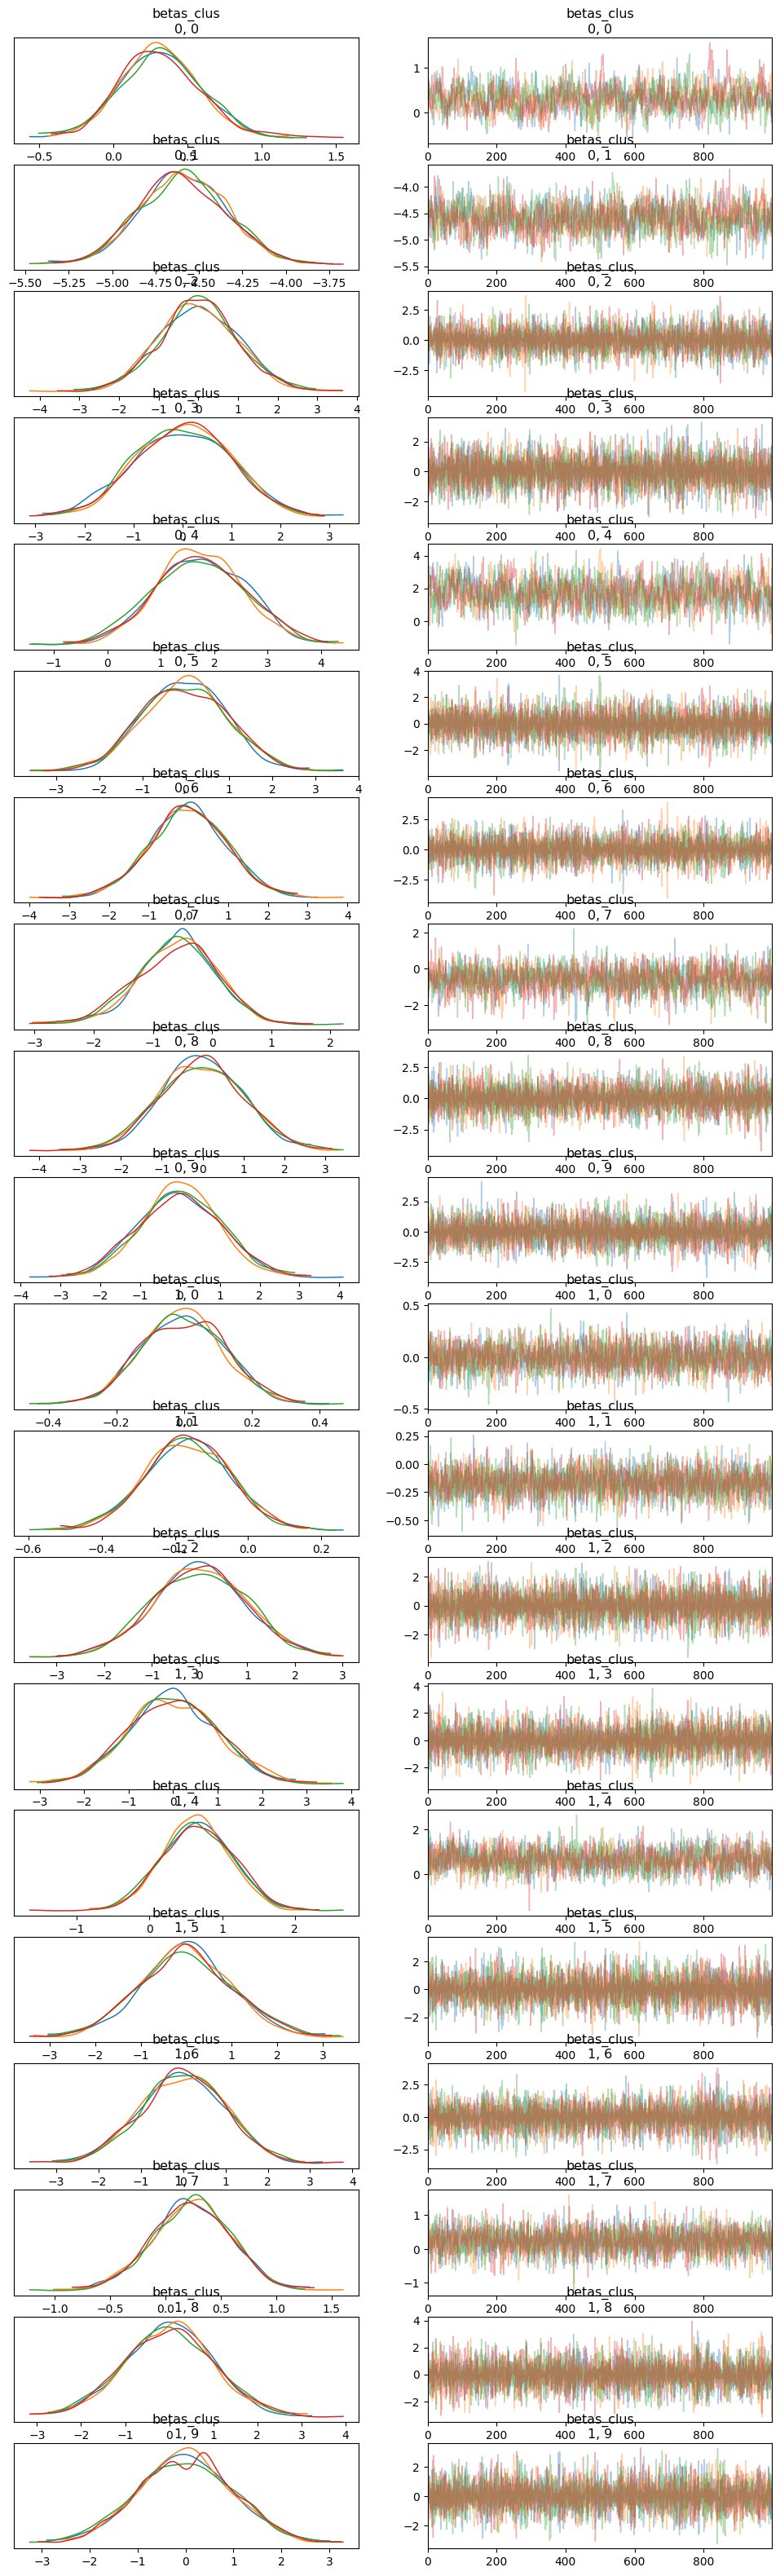

In [215]:
#betas[p,h] plot the betas specific to the clusters
fit_clus_az = az.from_cmdstanpy(fit_clus)
az.plot_trace(fit_clus, var_names=["betas_clus"], compact=False)
plt.show()


array([[<AxesSubplot: title={'center': 'betas_clus\n0, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 1'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 2'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 3'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 5'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 6'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 7'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 8'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 9'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 1'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n1, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 3'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 4'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n1, 5'}>,
        <AxesSubplo

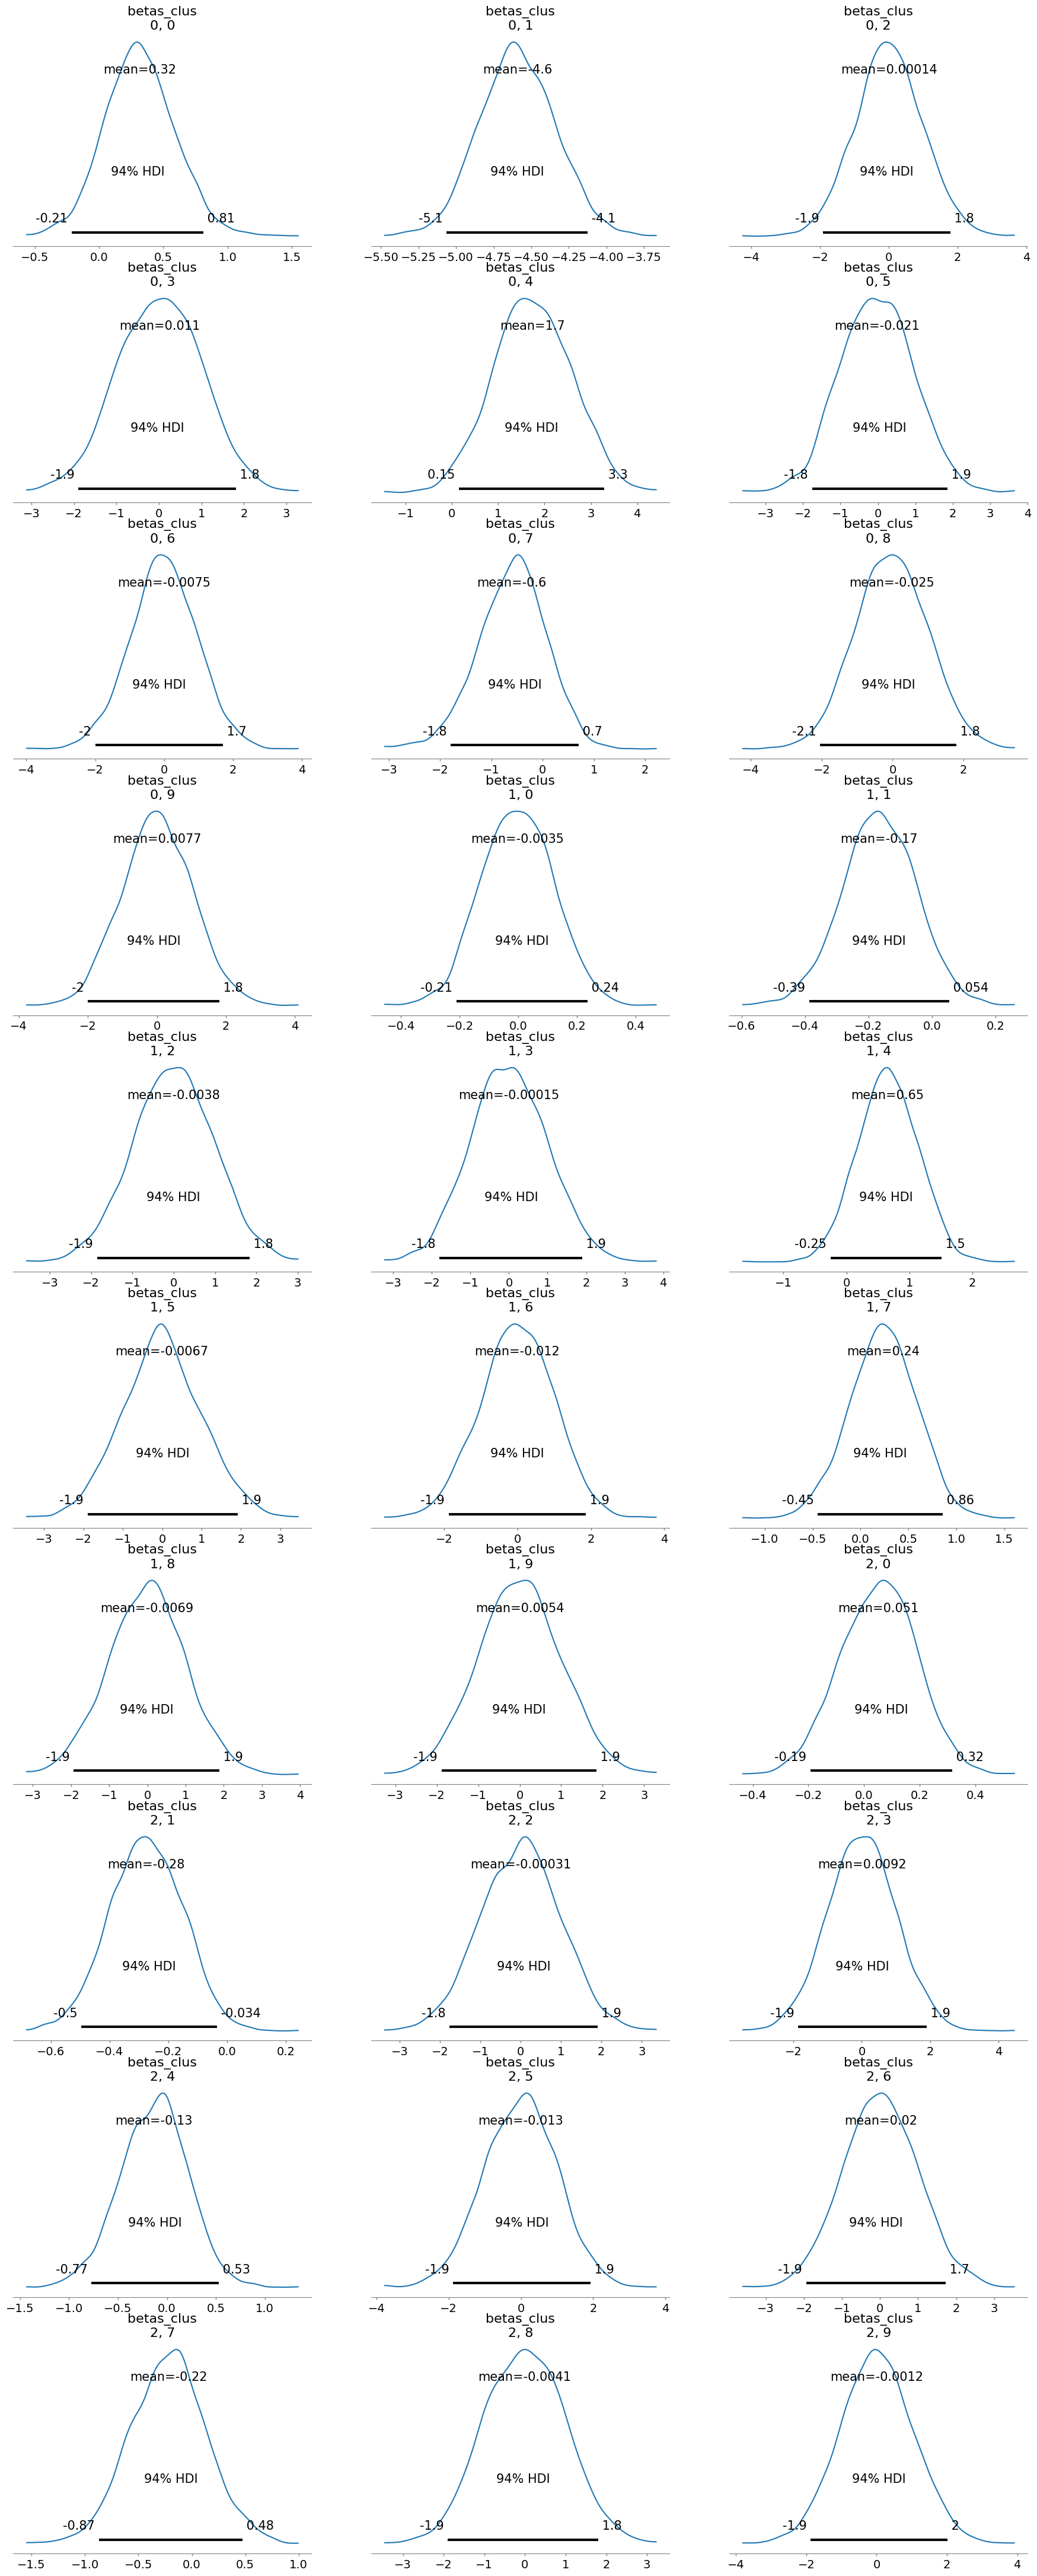

In [216]:
az.plot_posterior(fit_clus_az, var_names='betas_clus')

<AxesSubplot: >

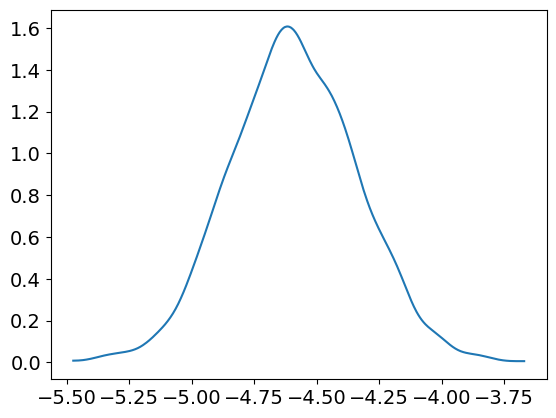

In [217]:
h=1   #plot the posterior of betas seen in cluster h

az.plot_dist(values=fit_clus_az.posterior.betas_clus.values[0:,0:,0,h])